# Global Analysis (Target analysis)





[Singluar Value Decomposition](#SVD) - what it is a how it can be helpfull with the analysis of kinetic data





Dimensions of matrices will be always denoted in this format: {$number\ of\ rows$} $\times$ {$number\ of\ columns$}

Great python colon operator summary is [here](https://www.programiz.com/python-programming/matrix).

## Some theory...


Beer–Lambert law

$$A(\lambda) = \varepsilon(\lambda)cl = -\log T(\lambda) =  -\log{\frac{I(\lambda)}{I_0(\lambda)}}$$

where $A(\lambda)$ is absorbance at wavelength $\lambda$, $\varepsilon(\lambda)$ is molar absorption coefficient of compound at wavelenth $\lambda$, $c$ is the concentration of that compound, $l$ is the length of cuvette, $T$ is a transmitance (the part of transmitted light), $I$ is intensity of transmitted light and $I_0$ is intensity of incident light. Beer–Lambert law is additive, so for $n$ absorbing species in the same measured solution, resulting absorbance will be

$$A(\lambda) = l\sum_{i=1}^n c_i\varepsilon_i(\lambda)$$

For time dependent measurement, where concentrations of species change in time, absorbance becomes dependent on time

$$A(\lambda, t) = l\sum_{i=1}^n c_i(t)\varepsilon_i(\lambda)$$

From transient measurement (or any spectroscopic kinetic measurement), we usually obtain a matrix $\overset{t\ \times\ w}{\mathbf{A}}$, where $t$ is number of measured times and $w$ is number of measured wavelengths. We can look at $\mathbf A$ as a column vector of dimension $t$. Then, it represents measured spectra for different times, thus, time evolution.

$$\mathbf A = \begin{bmatrix}
A(\lambda, t_1) \\
A(\lambda, t_2) \\
\vdots \\
A(\lambda, t) \end{bmatrix} $$

If we define concentration matrix $\overset{t\ \times\ n}{\mathbf{C}}$ and epsilon matrix $\overset{n\ \times\ w}{\mathbf{E}}$, we can construct the data matrix $\mathbf A$ by simply taking matrix product of $\mathbf C$ and $\mathbf E$. Each column of $\mathbf C$ is the concentration evolution for one species. Each row of $\mathbf E$ is 'spectrum' of one species. Here, for simplicity, we don't care about $l$, it is usually 1. It is just a scaling factor, we can add it later if we measured our sample in other that 1 cm cuvette.


$$\mathbf D  = \mathbf C \mathbf{S^T} $$


$$\mathbf A=
\begin{bmatrix}
     A_{11} & A_{12} & A_{13} & \dots  & A_{1w} \\
     A_{21} & A_{22} & A_{23} & \dots  & A_{2w} \\
     \vdots & \vdots & \vdots & \ddots & \vdots \\
     A_{t1} & A_{t2} & A_{t3} & \dots  & A_{tw} 
\end{bmatrix}=
\begin{bmatrix}
     c_{11} & c_{12}  & \dots  & c_{1n} \\
     c_{21} & c_{22}  & \dots  & c_{2n} \\
     \vdots & \vdots  & \ddots & \vdots \\
     c_{t1} & c_{t2}  & \dots  & c_{tn} 
\end{bmatrix}
\begin{bmatrix}
     \varepsilon_{11} & \varepsilon_{12}  & \dots  & \varepsilon_{1w} \\
     \varepsilon_{21} & \varepsilon_{22}  & \dots  & \varepsilon_{2w} \\
     \vdots & \vdots &  \ddots & \vdots \\
     \varepsilon_{n1} & \varepsilon_{n2}  & \dots  & \varepsilon_{nw} 
\end{bmatrix}=\mathbf C \mathbf E$$


The goal of global analysis is to reverse the process $-$ calculate $\mathbf C$ and $\mathbf E$ from $\mathbf A$. Lets start with creating some model data matrix $\mathbf A$. First, we define epsilon matrix $\mathbf E$. We will have 3 species ($n=3$) and we approximate the spectra as gaussian functions.


For further reading, I recomend the book by Meader$^{[1]}$ and very good article by Stokkum et.al.$^{[2]}$ and of course I cannot forget the Photochemisry textbook by Klán and Wirz$^{[3]}$



[1] Marcel Meader; Practical Data Analysis in Chemistry. 2007. Elsevier. ISBN: 978-0-444-53054-7 <br>
[2] van Stokkum, I. H. M., Larsen, D. S., & van Grondelle, R. (2004). Global and target analysis of time-resolved spectra. Biochimica et Biophysica Acta (BBA) - Bioenergetics, 1657(2–3), 82–104. https://doi.org/10.1016/j.bbabio.2004.04.011 <br>
[3] Klán, P.; Wirz, J. Photochemistry of Organic Compounds: From Concepts to Practice, 1st ed.; John Wiley & Sons Ltd.: Chichester, UK, 2009, ISBN: 978-1-405-16173-2

In [1]:
import numpy as np  # import numpy package (abbreviation stands for Numerical Python)
import matplotlib.pyplot as plt  # we plot graphs with this library

times = np.arange(0, 500)  # linear space of times from 0 to 499 in arbitrary units
wavelengths = np.arange(300, 600)  # linear space of wavelengths from 300 to 599 in arbitrary units

t, w = times.shape[0], wavelengths.shape[0]  # dimensions of times and wavelenths
t, w

def save_matrix(D, times, wavelengths, fname='output.txt', delimiter='\t', encoding='utf8', t0=None, t1=None, w0=None, w1=None):
    # cut data if necessary

    t_idx_start = find_nearest_idx(times, t0) if t0 is not None else 0
    t_idx_end = find_nearest_idx(times, t1) + 1 if t1 is not None else D.shape[0]

    wl_idx_start = find_nearest_idx(wavelengths, w0) if w0 is not None else 0
    wl_idx_end = find_nearest_idx(wavelengths, w1) + 1 if w1 is not None else D.shape[1]

    # crop the data if necessary
    D_crop = D[t_idx_start:t_idx_end, wl_idx_start:wl_idx_end]
    times_crop = times[t_idx_start:t_idx_end]
    wavelengths_crop = wavelengths[wl_idx_start:wl_idx_end]

    mat = np.vstack((wavelengths_crop, D_crop))
    buffer = delimiter + delimiter.join(f"{num}" for num in times_crop) + '\n'
    buffer += '\n'.join(delimiter.join(f"{num}" for num in row) for row in mat.T)

    with open(fname, 'w', encoding=encoding) as f:
        f.write(buffer)

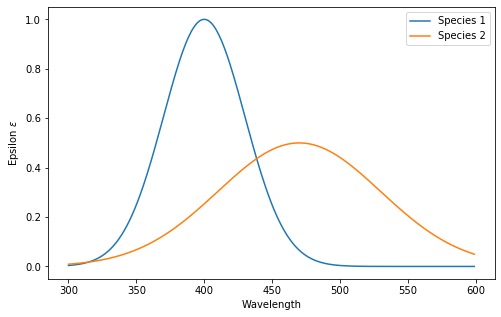

In [2]:
n = 2  # we will have 3 absorbing species
%matplotlib inline

C = np.zeros((t, n))  # define concentration matrix with dimensions t x n
ST = np.zeros((n, w))  # define epsilon matrix with dimensions n x w

# define gaussian function (without a scaling factor) for creating sample spectra
def gauss(x, mu, sigma):
    return np.exp(- (x - mu) * (x - mu) / (2 * sigma * sigma))

# fill epsilon matrix for all 3 species with generated spectra by gaussian function
ST[0] = gauss(wavelengths, 400, 30)
ST[1] = 0.5 * gauss(wavelengths, 470, 60)
# ST[2] = 0.9 * gauss(wavelengths, 450, 40)

# plot created spectra
plt.rcParams['figure.figsize'] = [8, 5]
for i in range(n):
    plt.plot(wavelengths, ST[i], label='Species {}'.format(i+1))
plt.xlabel('Wavelength')
plt.ylabel('Epsilon $\epsilon$')
plt.legend()
plt.show()

## Kinetic model

Now, we can create the concentration matrix $\mathbf C$. Since we have 3 species, lets use A$\rightarrow$B$\rightarrow$C kinetic model. In our case, all species will abosrb.

\begin{align}
\frac{\mathrm d[\mathrm A]}{\mathrm dt} & = -k_1[\mathrm A] \\
\frac{\mathrm d[\mathrm B]}{\mathrm dt} & = - k_2[\mathrm B] + k_1[\mathrm A]  \\
\frac{\mathrm d[\mathrm C]}{\mathrm dt} & = k_2[\mathrm B]
\end{align}

By solving the set of these differential equations for these initial conditions ($k_1 \neq k_2$),

$$[\mathrm A]_0 = c_0 \qquad [\mathrm B]_0 = [\mathrm C]_0 = 0$$
we get integrated forms:
\begin{align}
[\mathrm A] & = c_0e^{-k_1t} \\
[\mathrm B] & = \frac{c_0k_1}{k_2 - k_1}\left(e^{-k_1t} - e^{-k_2t}\right) \\
[\mathrm C] & = c_0 - [\mathrm A] - [\mathrm B]
\end{align}

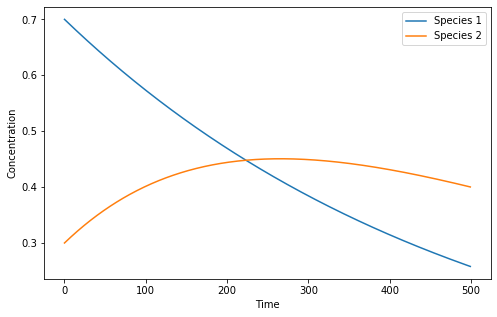

In [3]:
c0, k1, k2 = 1, 0.002, 0.003  # for simplification, we assume that c0 = 1

# fill concentration matrix for all 3 species, we use A->B->C kinetic model, where all species are visible
def calc_C(c0, k1, k2, C):
    C[:, 0] = c0 * np.exp(-k1 * times) * 0.7
    C[:, 1] = c0 * (k1 / (k2 - k1)) * (np.exp(-k1 * times) - np.exp(-k2 * times)) + np.exp(-k1 * times) * 0.3
#     C[:, 2] = c0 - C[:, 0] - C[:, 1]

calc_C(c0, k1, k2, C)

# plot computed concentrations
plt.rcParams['figure.figsize'] = [8, 5]
for i in range(n):
    plt.plot(times, C[:, i], label='Species {}'.format(i+1))
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()
plt.show()

We can now construct our data matrix by simply taking a matrix product of concentration matrix and epsilon matrix (the calculation looks really simple in matrix notation :) )

$$\mathbf A = \mathbf{CE}$$

In [4]:
# construct data matrix, @ is operator for dot product in python (version >= 3.5)
A = C @ ST

print(f"Dimensions of A: {A.shape}, total number of datapoins: {t*w}")  # matrix has dimensions t x w

save_matrix(A, times, wavelengths)

Dimensions of A: (500, 300), total number of datapoins: 150000


Now, we need to visualize our data. We could construct a 3D graph from our data, but it is not really convenient. Lets construct a typical plot, evolution of spectra over time. We can see that spectra does not have defined isosbestic point, because spectra consist of 3 individual components.

In the next plot, we visualized our data matrix $\mathbf A$ as a heat map. In this plot, the $z$ value of our data is plotted as color with defined color map. Also, we can pick specific columns of $\mathbf A$ to plot trace at specific wavelength. So, by picking rows from $\mathbf A$, we get spectra at specific time. By picking columns from $\mathbf A$, we get traces at specific wavelength.

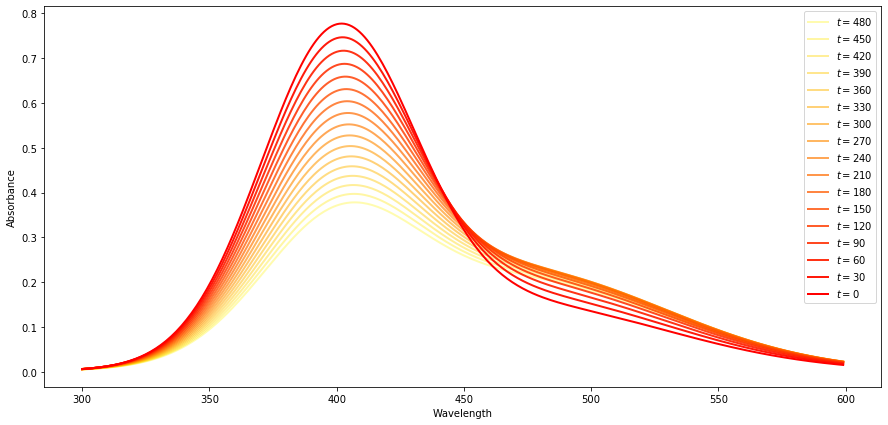

In [5]:
# plot evolution of spectra over time, time is depicted as color, linearly changing from red(t=0) to yellow(t=499)

plt.rcParams['figure.figsize'] = [15, 7]
for i in reversed(range(0, t, 30)):
    # vary alpha channel with time as well, so with increasing time, line becomes more transparent
    plt.plot(wavelengths, A[i], color=(1, i/t, 0, (t-i/1.4)/t), label='$t = {}$'.format(times[i]), lw=2)
plt.xlabel('Wavelength')
plt.ylabel('Absorbance')
plt.legend()
plt.show()

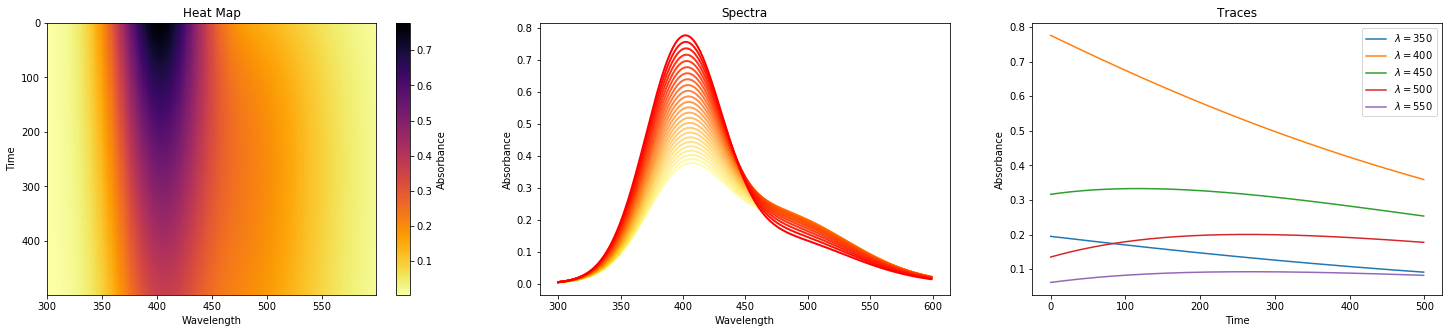

In [6]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm

# define custom color map, first column is the position on the color map, second column is the value of that color
# at the start of the region and 3rd column is value of that color at the end of the region (from 0 - 1)
# https://matplotlib.org/tutorials/colors/colormap-manipulation.html
# cdict = {'red':   ((0.0, 1.0, 1.0),
# #                    (1/3, 1.0, 1.0),
#                    (2/3, 1.0, 1.0),
#                    (1.0, 0.5, 0.5)),

#          'green': ((0.0, 1, 1),
#                    (1/3, 0.6, 0.6),
#                    (2/3, 0, 0),
#                    (1.0, 0.0, 0.0)),

#          'blue':  ((0.0, 1.0, 1.0),
#                    (1/3, 0.0, 0.0),
#                    (1.0, 0.0, 0.0)),
          
# #          'alpha': ((0.0, 0.0, 0.0),
# #                    (1/3, 1.0, 1.0),
# #                    (1.0, 1.0, 1.0))
#         }

cdict = {'red':   ((0.0, 0.0, 0.0),
                   (2/5, 0.0, 0.0),
                   (1/2, 1.0, 1.0),
                   (3/5, 1.0, 1.0),
                   (4/5, 1.0, 1.0),
                   (1.0, 0.3, 0.3)),

         'green': ((0.0, 0, 0),
                   (2/5, 0.0, 0.0),
                   (1/2, 1.0, 1.0),
                   (3/5, 1.0, 1.0),
                   (4/5, 0.0, 0.0),
                   (1.0, 0.0, 0.0)),

         'blue':  ((0.0, 0.3, 0.3),
                   (2/5, 1.0, 1.0),
                   (1/2, 1.0, 1.0),
                   (3/5, 0.0, 0.0),
                   (4/5, 0.0, 0.0),
                   (1.0, 0.0, 0.0))
        }

custom_cmap = LinearSegmentedColormap('diverging', cdict)
cm.register_cmap('diverging', custom_cmap)

# plot heat map, spectra and traces
def plot_A(A, times, wavelengths, cmap='inferno_r'):
    plt.rcParams['figure.figsize'] = [25, 5]
    plt.subplot(1, 3, 1)
    x, y = np.meshgrid(wavelengths, times)  # needed for pcolormesh to correctly scale the image
    plt.pcolormesh(x, y, A, cmap=cmap)
    plt.colorbar(label='Absorbance')
    plt.title("Heat Map")
    plt.xlabel('Wavelength')
    plt.ylabel('Time')
    plt.gca().invert_yaxis()
    
    plt.subplot(1, 3, 2)
    for i in reversed(range(0, t, 20)):
        plt.plot(wavelengths, A[i], color=(1, i/t, 0, (t-i/1.4)/t), label='$t = {}$'.format(times[i]), lw=2)
    plt.title("Spectra")
    plt.xlabel('Wavelength')
    plt.ylabel('Absorbance')
    # plt.legend()
    
    plt.subplot(1, 3, 3)
    for i in range(50, w, 50):
        plt.plot(times, A[:, i], label='$\lambda = {}$'.format(wavelengths[i]))
    plt.title("Traces")
    plt.xlabel('Time')
    plt.ylabel('Absorbance')
    plt.legend()
    
    plt.show()

plot_A(A, times, wavelengths)   

<a id='SVD'></a>
## Singular value decomposition

With our sample matrix $\mathbf A$, we can now try to guess matrices $\mathbf C$ and $\mathbf E$. Singular value decomposition will help us identify, how many components our system is composed of and from that knowledge. Next, we will decompose the large matrix $\mathbf A$ into only 3 small matrices. This will then greatly speed up the fitting procedure.

By applying SVD (Singular value decomposition) to $\boldsymbol{\mathrm{A}}$, we can rewrite 

Data matrix $\boldsymbol{\mathrm{A}}$ with dimensions $t\times w$, where $t$ is number of measured times and $w$ is number of measured wavelenghts, can be respresented by as a product of three matrices. 

$$\mathbf A = \mathbf{U\Sigma V^T}$$

left side vectors are orthonormal eigenvectors
right side vectors are orthonormal eigenvectors

Orthogonality - the two vectors are orthogonal, if and only if their dot product is 0.

$$\langle f_i, f_j\rangle = \delta_{i,j}$$

$$\mathbf{V^{-1}V = V^TV = I = U^TU = U^{-1}U}$$

Kronecker delta

Orthonormality - the vector are orthonormal, if and only if they are orthogonal and normalized, so that the size is 1.

$$\parallel f_i\parallel = 1$$



Nice explanation of SVD is [here](https://www.quora.com/What-is-an-intuitive-explanation-of-singular-value-decomposition-SVD).


In [7]:
from scipy.linalg import svd  # import svd function from scipy library

# we don't need full matrices, furthermore, computation is a lot faster and memory benign
U, S, V_T = svd(A, full_matrices=False)

print(U.shape, S.shape, V_T.shape)  # !Sigma is returned as a simple 1D array, not a diagonal matrix!

(500, 300) (300,) (300, 300)


In [8]:
S[:5]  # show first 5 singular values

array([1.06955193e+02, 9.71359402e+00, 3.54880324e-14, 1.59818477e-14,
       1.23952654e-14])

## Visualize found column and row vectors and reconstruct the matrix for 3 non-zero singular values.

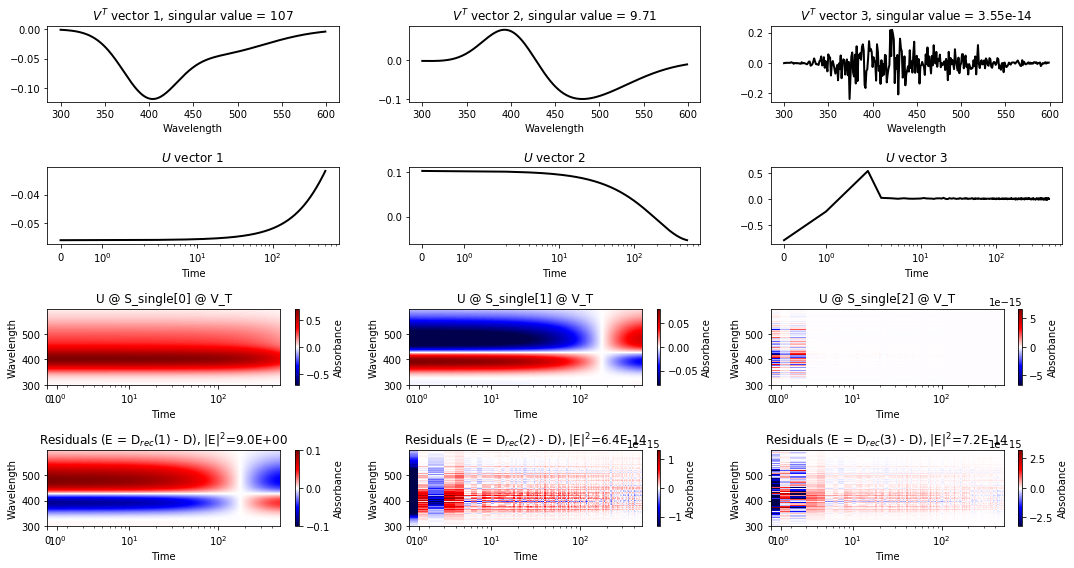

In [9]:
def plot_first_n_vectors(n, U, S, V_T, times, wavelengths):
    S_single = []  # define a list of diagonal matrices with only one singular value
    for i in range(n):
        S_i = np.zeros((S.shape[0], S.shape[0]))  # recreate diagonal matrices
        S_i[i, i] = S[i]
        S_single.append(S_i)
    
    plt.rcParams['figure.figsize'] = [15, 8]
    x, y = np.meshgrid(times, wavelengths)  # needed for pcolormesh to correctly scale the image
    for i in range(n):
        plt.subplot(4, n, i+1)
        plt.plot(wavelengths, V_T[i], color='black', lw=2)
        plt.title("$V^T$ vector {}, singular value = {:.3g}".format(i+1, S[i]))
        plt.xlabel('Wavelength')
    for i in range(n):
        plt.subplot(4, n, i+n+1)
        plt.xscale('symlog', subsx=[1,2,3,4,5,6,7,8,9])

        plt.plot(times, U[:, i], color='black', lw=2)
        plt.title(f"$U$ vector {i+1}")
        plt.xlabel('Time') 
    for i in range(n):
        plt.subplot(4, n, i+2*n+1)
        plt.xscale('symlog', subsx=[1,2,3,4,5,6,7,8,9], linscalex=0.2)

        A_rec = U @ S_single[i] @ V_T  # reconstruct the A matrix for this i-th component
        # setup z range so that white color corresponds to 0
        plt.pcolormesh(x, y, A_rec.T, cmap='seismic', vmin=-np.abs(np.max(A_rec)), vmax=np.abs(np.max(A_rec)))
        plt.colorbar(label='Absorbance')
        plt.title(f"U @ S_single[{i}] @ V_T")
        plt.ylabel('Wavelength')
        plt.xlabel('Time')
        
        plt.subplot(4, n, i + 3 * n + 1)
        plt.xscale('symlog', subsx=[1,2,3,4,5,6,7,8,9], linscalex=0.2)

        Sd = np.diag(S) # create sigma diagonal matrix from S
        Ur = U[:, :i+1]
        Sr = Sd[:i+1, :i+1]
        V_Tr = V_T[:i+1, :]
        Ar = Ur @ Sr @ V_Tr
        A_diff = Ar - A
        
#         E2 = (A_diff * A_diff).sum()
        E2 = 100 * np.sqrt((A_diff * A_diff).sum() / (A*A).sum()) 

        
        plt.pcolormesh(x, y, A_diff.T, cmap='seismic', vmin=-np.abs(np.max(A_diff)), vmax=np.abs(np.max(A_diff)))
        plt.colorbar(label='Absorbance')
        title = "Residuals (E = D$_{{rec}}$({}) - D)".format(i+1)
        plt.title(title + f", |E|$^2$={E2:.1E}")
        plt.ylabel('Wavelength')
        plt.xlabel('Time')
    plt.tight_layout()
    plt.show()
    

plot_first_n_vectors(3, U, S, V_T, times, wavelengths)

## Logaritmic plot of singular values

Another great tool, how to estimate number of significant components in the system is the plot of first $n$ singular values, keeping y axis in log scale. We can see from the below graph, that only first 3 components are significant, which is correct, because we constructed the matrix from 3 individual spectra. The other values are not zero, but are extremally small ($\sim 10^{-13}$) because of floating point errors during all computations.

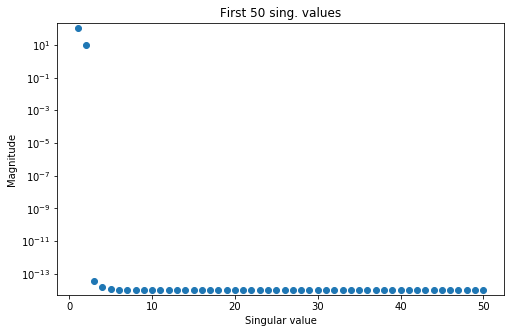

In [10]:
def plot_log_S(S, n):
    x_data = range(1, n + 1)
    
    plt.rcParams['figure.figsize'] = [8, 5]
    
    plt.scatter(x_data, S[:n])
    plt.yscale('log')
    plt.ylabel('Magnitude')
    plt.xlabel('Singular value')
    min, max = np.min(S[:n]), np.max(S[:n])
    plt.ylim(min / 2, 2 * max)  # setup y range correctly
    plt.title(f'First {n} sing. values')
    
    plt.show()

plot_log_S(S, 50)

In [11]:
a = V_T[0].reshape(w, 1)
b = V_T[1].reshape(1, w)

# test for example that first two V_T vectors are orthonormal, 
# result is not zero and exactly one because of floating point errors
b @ a, np.sqrt(np.sum(a*a)), np.sqrt(np.sum(b*b))

(array([[7.99599102e-18]]), 1.0000000000000004, 1.0)

In [12]:
np.dot(V_T[0], V_T[0])

1.0000000000000009

### Truncated SVD and projection to basic vectors

projection to 

In [13]:
nr = 2

Ur = U[:, :nr]  # reduce the U matrix
Sr = np.diag(S)[:nr, :nr]  # create a diagonal matrix sigma and reduce it
Vr_T = V_T[:nr, :]  # reduces the V_T matrix
Vr = Vr_T.T

print(Ur.shape, Sr.shape, Vr_T.shape)

(500, 2) (2, 2) (2, 300)


In [14]:
Vr.T @ Vr  # V^T x V = I

array([[ 1.00000000e+00, -1.80411242e-16],
       [-1.80411242e-16,  1.00000000e+00]])

In [15]:
Ur.T @ Ur  # U^T x U = I

array([[1.00000000e+00, 5.55111512e-17],
       [5.55111512e-17, 1.00000000e+00]])

In [16]:
proj_V = A @ Vr_T.T
# proj_V[:, 2]


In [17]:
A_p = proj_V @ Vr_T
# plot_A(A_p, times, wavelengths)  
np.allclose(A, A_p)  # reconstruciton of a reaction from projection matrix yields the A

True

### Projection to $\mathbf V$ basis

$$\mathbf A = \mathbf{U\Sigma V^T} = \mathbf{CS^T}$$

Truncated SVD

$$\boldsymbol{\mathrm{A_r}} \approx \boldsymbol{\mathrm{U_r}}\ \boldsymbol{\mathrm{S_r}}\ \boldsymbol{\mathrm{V^T_r}}=\mathbf{CS^T}$$

Projection matrix

$$\mathbf{P_V} = \mathbf{AV}$$

$$\mathbf{A} = \mathbf{P_VV^{-1} = P_VV^T}$$

No handles with labels found to put in legend.


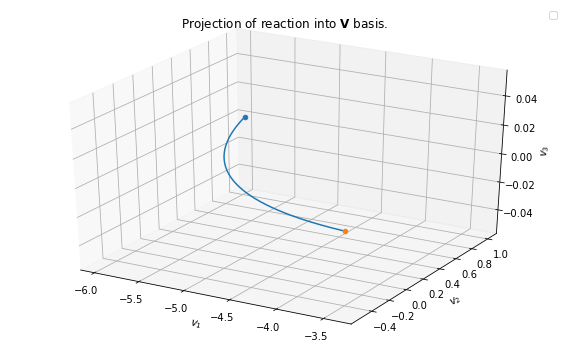

In [18]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib qt

plt.rcParams['figure.figsize'] = [8, 5]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(proj_V[:, 0], proj_V[:, 1])#, proj_V[:, 2])
ax.scatter(proj_V[0, 0], proj_V[0, 1])#, proj_V[0, 2], label=f't={times[0]}')
ax.scatter(proj_V[-1, 0], proj_V[-1, 1])#, proj_V[-1, 2], label=f't={times[-1]}')

ax.set_xlabel("$v_1$")
ax.set_ylabel("$v_2$")
ax.set_zlabel("$v_3$")
ax.set_title("Projection of reaction into $\mathbf{V}$ basis.")

plt.legend()
plt.tight_layout()
plt.show()


### Rotation matrix R

\mathbf A = \mathbf{CS^T = CR^{-1}RS^T=C_{new}S_{new}^T}

$$\mathbf{V^{-1}V = V^TV = I = U^TU = U^{-1}U}$$

$$\mathbf{A = U\Sigma V^T = U\Sigma R^{-1}RV^T}$$

$$\mathbf{C = U\Sigma R^{-1} \qquad S^T = RV^T}$$

$$\mathbf R = \begin{bmatrix}
     1 & R_{12} & R_{13} \\
     R_{21} & 1 & R_{23} \\
     R_{31} & R_{32} & 1  
\end{bmatrix}$$


$$\mathbf{R = S^T V}$$

In [33]:
%matplotlib inline

R = ST @ Vr
R
ST.shape

(2, 300)

In [34]:
print(np.allclose(R @ Vr.T, ST))  # S^T == R V^T
print(np.allclose(Ur @ Sr @ np.linalg.inv(R), C))  # C == U x sigma R^-1

True
True


In [35]:
def ssq(R):
    
    ST_new = R @ Vr.T
    C_new = Ur @ Sr @ np.linalg.inv(R)
#     C_new = np.linalg.lstsq(ST_new.T, A.T)[0].T

    # apply non-*negativlity constaint
    ST_new *= ST_new > 0
    C_new *= C_new > 0
    
    A_new = C_new @ ST_new
    return A_new, C_new, ST_new, np.sum((A - A_new) ** 2)

In [36]:
# normalize R
R = ST @ Vr
R = np.diag(1 / np.abs(np.diag(R))) @ R
R

array([[-1.        ,  0.40703788],
       [-1.34785665, -1.        ]])

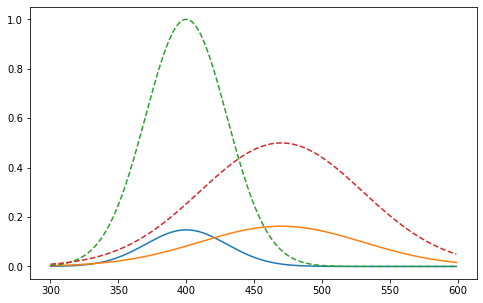

In [38]:
# plot spectra for different Rs
R = ST @ Vr
R = np.diag(1 / np.abs(np.diag(R))) @ R

R[0, 1] = 0.40703788
R[1, 0] =   -1.34785665

ST_new = R @ Vr.T
ST_new *= ST_new > 0
plt.rcParams['figure.figsize'] = [8, 5]
plt.plot(wavelengths, ST_new.T)
plt.plot(wavelengths, ST.T, '--')
plt.show()

4.744159104380159e-27


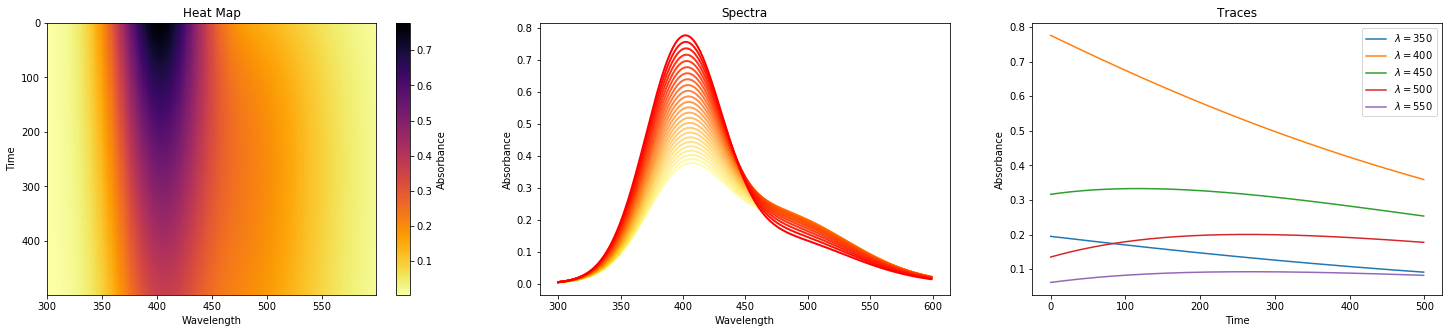

In [30]:
A_new, C_new, ST_new, s = ssq(R)
print(s)
plot_A(A_new, times, wavelengths)   

## Area of feasible solutions (AFS)

In [39]:
m = 100
par1 = np.linspace(0, 0.75, m)
par2 = np.linspace(-9, 0, m)

log_ssqs = np.zeros((m, m), dtype=np.float64)

for i in range(m):
    for j in range(m):
        
        R[0, 1] = par1[i]
        R[1, 0] = par2[j]
        
        if np.isclose(par1[i], 1/par2[j]):  # singularity
            log_ssqs[i, j] = np.nan
            continue
        
        A_new, C_new, ST_new, s = ssq(R)
        log_ssqs[i, j] = np.log10(s)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]


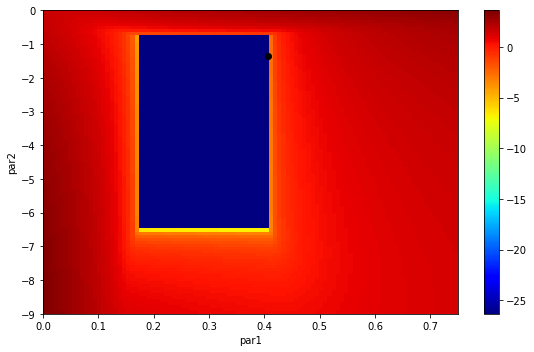

In [41]:
# %matplotlib qt
plt.rcParams['figure.figsize'] = [8, 5]
fig = plt.figure()
ax = fig.add_subplot(111)

X, Y = np.meshgrid(par1, par2)
# log_ssqs[log_ssqs < -5] = -5

m = ax.pcolormesh(X, Y, log_ssqs.T, cmap='jet')

ax.scatter(0.40703788, -1.34785665, color='black')

ax.set_xlabel("par1")
ax.set_ylabel("par2")
plt.colorbar(mappable=m)
# ax.set_zlabel("log ssq")
# ax.set_title("Projection of reaction into $\mathbf{V}$ basis.")

# plt.legend()
plt.tight_layout()
plt.show()


In [42]:
AFS = np.argwhere(log_ssqs < -25)

par1s = par1[AFS[:, 0]]
par2s = par2[AFS[:, 1]]

Ss_new = np.zeros((par1s.shape[0], ST.shape[0], ST.shape[1]))
Cs_new = np.zeros((par1s.shape[0], C.shape[0], C.shape[1]))

for i in range(par1s.shape[0]):
    R[0, 1] = par1s[i]
    R[1, 0] = par2s[i]

    A_new, C_new, ST_new, s = ssq(R)
    Ss_new[i] = ST_new
    Cs_new[i] = C_new



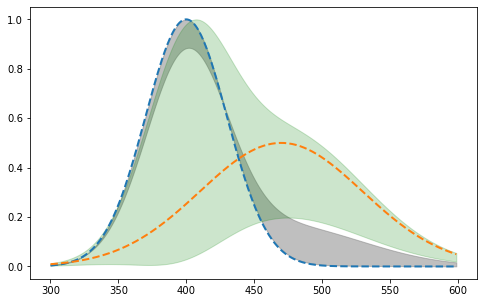

In [43]:
plt.rcParams['figure.figsize'] = [8, 5]

S1s = np.asarray([Ss_new[i, 0, :] for i in range(Ss_new.shape[0])])
S2s = np.asarray([Ss_new[i, 1, :] for i in range(Ss_new.shape[0])])

S1_ranges = np.vstack((S1s.min(axis=0, keepdims=False), S1s.max(axis=0, keepdims=False)))
S2_ranges = np.vstack((S2s.min(axis=0, keepdims=False), S2s.max(axis=0, keepdims=False)))


# plt.plot(wavelengths, S1s[::100].T, color='gray', lw=0.5)
# plt.plot(wavelengths, S2s[::100].T, color='green', lw=0.5)

plt.fill_between(wavelengths, S1_ranges[0] / S1_ranges[1].max(), S1_ranges[1]/ S1_ranges[1].max(), color='gray', alpha=0.5)
plt.fill_between(wavelengths, S2_ranges[0] / S2_ranges[1].max(), S2_ranges[1]/ S2_ranges[1].max(), color='green', alpha=0.2)


plt.plot(wavelengths, ST.T, '--', lw=2)
plt.show()

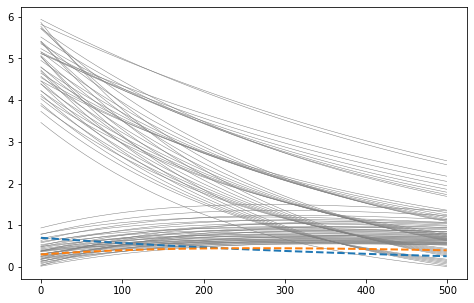

In [142]:
for _C in Cs_new[::50]:
    plt.plot(times, _C, color='gray', lw=0.5)
plt.plot(times, C, '--', lw=2)
plt.show()

## Global fit

Now, we are ready for the global fit, but first some theory.

$$\mathbf A = \mathbf{U\Sigma V^T} = \mathbf{CE}$$

$$\boldsymbol{\mathrm{Y_r}} = \boldsymbol{\mathrm{U_r}}\ \boldsymbol{\mathrm{S_r}}\ \boldsymbol{\mathrm{V^T_r}}=\boldsymbol{\mathrm{C}}\ \boldsymbol{\mathrm{A}}$$

Spectra matrix $\boldsymbol{\mathrm{A}}$ must be linear combination of $\boldsymbol{\mathrm{V^T_r}}$ row vectors. Let's define a coefficient matrix $\boldsymbol{\mathrm{K}}$.

$$\boldsymbol{\mathrm{A}} = \boldsymbol{\mathrm{K}}\ \boldsymbol{\mathrm{V^T_r}}$$


In actual fitting, we don't need to compute with all of the data matrix $\boldsymbol{\mathrm{Y}}$, but we utilize the SVD that we performed.


$$\boldsymbol{\mathrm{U_r}}\ \boldsymbol{\mathrm{S_r}}\ \boldsymbol{\mathrm{V^T_r}} = \boldsymbol{\mathrm{C}}\ \boldsymbol{\mathrm{K}}\ \boldsymbol{\mathrm{V^T_r}}$$

$$\boldsymbol{\mathrm{U_r}}\ \boldsymbol{\mathrm{S_r}} = \boldsymbol{\mathrm{C}}\ \boldsymbol{\mathrm{K}}$$

To estimate $\boldsymbol{\mathrm{K}}$ from this matrix equation, we mutiply both sides of the equation from the left by $\boldsymbol{\mathrm{C^+}}$, which is Moore-Penrose pseudoinverse of concentration matrix. $\boldsymbol{\mathrm{C^+}} = \left(\boldsymbol{\mathrm{C^T}}\boldsymbol{\mathrm{C}}\right)^{-1}\boldsymbol{\mathrm{C^T}}$.

$$\boldsymbol{\mathrm{C^+}}\boldsymbol{\mathrm{U_r}}\ \boldsymbol{\mathrm{S_r}} = \boldsymbol{\mathrm{C^+}}\boldsymbol{\mathrm{C}}\ \boldsymbol{\mathrm{K}}$$

$$\boldsymbol{\mathrm{C^+}}\boldsymbol{\mathrm{U_r}}\ \boldsymbol{\mathrm{S_r}} = \boldsymbol{\mathrm{I}}\ \boldsymbol{\mathrm{K}}$$

$$\boldsymbol{\mathrm{C^+}}\boldsymbol{\mathrm{U_r}}\ \boldsymbol{\mathrm{S_r}} = \boldsymbol{\mathrm{K}}$$

This is just a classical operator equation Ax=B, system of linear equations. We solve it by least squares.


In [291]:
from scipy.linalg import lstsq
# lmfit is a great library, it is a wrapper around scipy.optimize.minimize and curve_fit with many other stuff
from lmfit import Parameters, report_fit, Minimizer

# initialize concentration, epsilon and coefficient matrices
C_guess = np.zeros((t, n))
E_guess = np.zeros((n, w))
K = np.zeros((n, nr))

# define parameters through lmfit class Parameters, we keep c0 fixed to 1
# specify initial values, bounds and if the we want parameters to be fixed (vary=False) or be fitted (vary=True)
params = Parameters()
params.add('c0', value=1, min=0, max=np.inf, vary=False)
params.add('k1', value=1, min=0, max=np.inf, vary=True)
params.add('k2', value=0.5, min=0, max=np.inf, vary=True)

for par in params.items():
    print(par[1].value)

# this is our A->B->C model, since the k1 can be equal to k2 during fitting, we have to define also model model for k1=k2, the equation for it is different,
# othervise, we would get zero division errors. This process can be avoided by numerical integration, which is convenient for more complicated models
def calc_C(c0, k1, k2, C):
    diff = 1e-8
    C[:, 0] = c0 * np.exp(-k1 * times)  # [A] = c0 * exp(-k1 * t)
    if np.abs(k1 - k2) < diff:  # k1 == k2
        C[:, 1] = c0 * k1 * times * np.exp(-k1 * times)  # [B] = c0 * k1 * t * exp(-k1 * t)
    else:
        C[:, 1] = c0 * (k1 / (k2 - k1)) * (np.exp(-k1 * times) - np.exp(-k2 * times))  # [B] = c0 * (k1 / (k2 - k1)) * (exp(-k1 * t) - exp(-k2 * t))
    C[:, 2] = c0 - C[:, 0] - C[:, 1]  # [C] = c0 - [A] - [B]

# calculate dot product of Ur and Sr beforehand
UrSr = Ur @ Sr
print(UrSr.shape)

# define residuals function that will be minimized
def residuals(params):
    global K, E_guess  # this command does not have anything to do with global analysis, we just make K and E_guess global variables (not local) :)
    c0, k1, k2 = params['c0'].value, params['k1'].value, params['k2'].value
    # calculate concetration matrix according to our model for parameters c0, k1 and k2
    calc_C(c0, k1, k2, C_guess)
    # calculates the coefficient matrix K, this is shortcut of computing C_guess+ @ Ur @ Sr, so no need to calculate pseudoinverse
    K = lstsq(C_guess, UrSr)[0]
    # calculate epsilon matrix according to just computed K
    E_guess = K @ Vr_T
    # construct data matrix from C_guess and E_guess
    A_guess = C_guess @ E_guess
    # calculate the residuals, here, we don't add any weights to the residual matrix (assuming the weights are 1)
    R = A - A_guess
    # return matrix of residuals
    return R

# define minimizer, needed for calculation of confidence intervals
m = Minimizer(residuals, params)

# minimize the residuals for two parameters k1 and k2, c0 is fixed
result = m.minimize(method='leastsq')  # leastsq - Lavenberg-Marquardt algorithm, other are possible as well

# report_fit function creates the report and prints it (function fit_report only return report as a string)
report_fit(result)

1
1
0.5
(500, 2)


IndexError: index 2 is out of bounds for axis 1 with size 2

## Fitted spectra

Now, we can see, that both parameters $k_1$ and $k_2$ are basically the same as original parameters that we used to construct the data. We can now plot the found spectra and compare them to gaussian spectra we used to construct the data. Result is really accurate, given the amount of noise, that we added to the data. Here we can appreciate the power of Singular value decomposition.

In [ ]:
plt.rcParams['figure.figsize'] = [12, 8]
for i in range(n):
    plt.plot(wavelengths, E[i], label=f'Species {i+1}', lw=3)
for i in range(n):
    plt.plot(wavelengths, E_guess[i], label='Fit', color=(0, 0, 0, 0.7), lw=2)
plt.xlabel('Wavelength')
plt.ylabel('Epsilon $\epsilon$')
plt.legend()
plt.show()

## Confidence intervals and correlation between parameters

The error of parameters in fit report are given in the confidence level of $1\sigma$. That is 68.27% probability that the value lies in the interval $\left(\overline{x} - \sigma, \overline{x} + \sigma\right)$, where $\overline{x}$ is the average value. Errors are calculated from the covariance matrix. For modern and correct estimation of confindence intervals, we can use the functions in [lmfit package](https://lmfit.github.io/lmfit-py/confidence.html). Read for more information, but in sumary, in some models (eg. sum of exponentials), estimation of parameter errors from covariance matrix could be wrong. Lmfit package provides function to calculate confidence intervals for these parameters correctly. Also, 2D confidence plot for two parameters is possible. The calculation takes some time, because the parameters are varied and others reoptimized by fitting. This can be really computationaly demanding for complicated models.

The below code prints confidence intervals for $1\sigma$, $2\sigma$ and $3\sigma$. The confidence intervals are symetrical and errors at $1\sigma$ are comparable to that estimated directly from fitting, so the estimation from covarinace matrix is correct and this analysis wouldn't be necessary. The next cell shows 2D correlation of $k_1$ and $k_2$. We can see that it is a nice elipse, so it really behaves normally.

There is also possibility to estimate confidence intervals and correlations by Markov Chain Monte Carlo (MCMC), for that, see the above link to lmfit package.

In [123]:
from lmfit import report_ci, conf_interval

ci = conf_interval(m, result, sigmas=(1, 2, 3))
report_ci(ci)

       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 k1:  -0.00006  -0.00004  -0.00002   0.01500  +0.00002  +0.00004  +0.00006
 k2:  -0.00004  -0.00002  -0.00001   0.00800  +0.00001  +0.00002  +0.00004


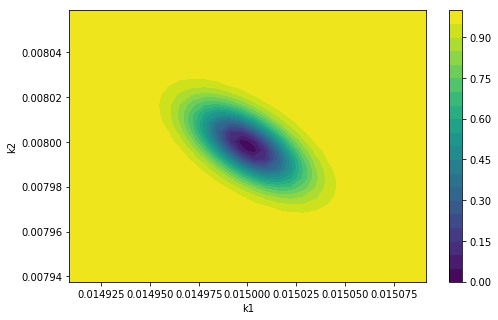

In [124]:
from lmfit import conf_interval2d

def confidence_interval2D(x_name: str, y_name: str, nx: float = 10, ny: float = 10):
    cx, cy, grid = conf_interval2d(m, result, x_name, y_name, nx, ny)
    plt.rcParams['figure.figsize'] = [8, 5]
    plt.contourf(cx, cy, grid, np.linspace(0, 1, 21))
    plt.xlabel(x_name)
    plt.colorbar()
    plt.ylabel(y_name)
    plt.show()

confidence_interval2D('k1', 'k2', 30, 30)

In [126]:
import timeit

%timeit m.minimize(method='leastsq')

22.5 ms ± 593 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Final remarks and discussion
